# MultiClass Text Classification-News Article

Text classification is a supervised learning technique so we’ll need some labeled data to train our model. I’ll be using this public news classification dataset. It’s a manually labeled dataset of news articles which fit into one of 4 classes: Business, SciTech, Sports or World.

## Table of Contents
1. [Importing dependencies](#p1)
2. [Importing dataset](#p2)
3. [Data Preprocessing](#p3)
4. [Data Analysis](#p4)
5. [Splitting the Data](#p5)
6. [TF-IDF Vectoriser](#p6)
7. [Dimensionality Reduction - TruncatedSVD](#p7)
8. [Creating and Evaluating Models](#p8)
    * [Logistic Regression](#p8-1)
    * [XGB Classifier](#p8-2)

## <a name="p1">Importing Dependencies</a>

In [1]:
# importing all the necessary libraries

import pandas as pd
import numpy as np
import json

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# importing NLTK libraries

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import itertools, string, operator, re, unicodedata, nltk
from operator import itemgetter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer, word_tokenize
from nltk import pos_tag
from bs4 import BeautifulSoup
from itertools import combinations
from gensim.models import Phrases
from collections import Counter
import time

## <a name="p2">Importing dataset</a>

In [3]:
#As we have the data in Json format hence loading the data from JSON file into a dataframe

data = []

for file in open("./data/News_Classification_DataSet.json", 'r'):
    data.append(json.loads(file))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


## <a name="p3">Data Preprocessing</a>

In [4]:
# Defined a method with all preprocessing functions

# Remove all non alphabets
def removing_nonalphabets(text):
    alphaPattern = "[^a-zA-Z]"
    finalText = re.sub(alphaPattern, " ", text)
    return finalText

# Removes all punctuations if any
def remove_punctuations(text):
    all_char_list = []
    all_char_list = [char for char in text if char not in string.punctuation]
    text = ''.join(all_char_list)

    
# Removing all the stopwords
add_stop = ['', ' ', 's', 'u', 'ap', 'afp', 'say', '...', 'n', '\\']
stop = stopwords.words('english')
stop_words = stop + add_stop
def remove_stopWords(text):
    cleanText = []
    no_stop = [word for word in text if word not in stop_words]
    cleanText = ' '.join(no_stop)
    return cleanText


# Considering words whose word length is greater than 1
def ignore_less_word_length(text):
    cleanText = []
    cleanW = [word for word in text if len(word)>1]
    cleanText = ' '.join(cleanW)
    return cleanText


#Removing URL
def remove_URL(text):
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    finalText = re.sub(urlPattern, " ", text)
    return finalText    
    

# Converting all text to lowercase
def to_lowerCase(text):
    text = text.lower()
    return text


# Defining a method to return the 2nd parameter for lemmatization that is POS tag
def get_wordnet_pos_tag(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

    
# Created a method to perform lemmatization with POS tags identified via a pos_tag method
lemma = WordNetLemmatizer()
def lemmatize_process(preprocessedtext):
    text_pos = pos_tag(word_tokenize(preprocessedtext))
    words = [x[0] for x in text_pos]
    pos = [x[1] for x in text_pos]
    text_lemma = " ".join([lemma.lemmatize(a,get_wordnet_pos_tag(b)) for a,b in zip(words,pos)])
    return text_lemma

 
    
# Finaly created a method to call all the operations one after another in a sequence
def process_text(text):
    finalText = ""
    lower = to_lowerCase(text)
    noUrl = remove_URL(lower)
    onlyalphabets = removing_nonalphabets(noUrl)
    
    lemmatized = lemmatize_process(onlyalphabets)
    word_tokens1 = word_tokenize(lemmatized)
    noStopWords = remove_stopWords(word_tokens1)
    word_tokens2 = word_tokenize(noStopWords)
    ignoreLessWord = ignore_less_word_length(word_tokens2)
    finalText = word_tokenize(ignoreLessWord)
        
    return finalText

In [5]:
# Applying the entire text stored in list "text" for preprocessing and calculating the time taken to perform the operation
t = time.time()
df['clean_text'] = df['content'].apply(process_text)
print('Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 25 seconds


In [6]:
# Printing the head of the dataframe to verify the changes
df.head()

,content,label,clean_text
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space, com, toronto, canada, second, team, ro..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, found, chemistry, researcher, univer..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[barely, dawn, mike, fitzpatrick, start, shift..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california, smog, fight, agency, go..."


## <a name="p4">Data Analysis</a>

In [7]:
# Created a method to print the word frequency which accepts 2 parameters, 
# one is the entire data in list format and other is how many top frequntly occuring words we want to print
def word_freq(clean_text_list, top_n):
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [8]:
#Top 20 most frequent words for all the articles
cl_text_list = df['clean_text'].tolist()
wf = word_freq(cl_text_list, 20)
wf.head(20)

,0,1
0,new,1082
1,year,869
2,reuters,793
3,company,631
4,two,617
5,first,578
6,quot,551
7,one,502
8,tuesday,502
9,monday,500


In [9]:
# Method to extract the word count given a dataset
def word_count(text):
    return len(str(text).split(' '))

In [10]:
# Avg word count by category
df['word_count'] = df['content'].apply(word_count)
avg_wc = df.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,Business,31.36
1,SciTech,30.77
2,Sports,31.35
3,World,31.74


In [11]:
# Checking the distribution of records per category
df['label'].value_counts()

Sports      1900
Business    1900
SciTech     1900
World       1900
Name: label, dtype: int64

#### All of the classes are perfectly balanced which is something I didn't observe in my other problem statements as well hence I will take a sub sample of the business and sports categories to make it imbalanced (that is more realistic). I’ll do 1000 from Business and 800 from Sports.

In [12]:
#Splitting the df into the different categories
df_business = df.loc[df['label'] == 'Business'] 
df_sports = df.loc[df['label'] =='Sports']
df_scitech = df.loc[df['label'] == 'SciTech'] 
df_world = df.loc[df['label'] =='World']


#Randomly sampling business and sports to create imbalanced classes
df_business = df_business.sample(n=1005, random_state=3)
df_sports = df_sports.sample(n=805, random_state=3)


#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

# Considering the remaining data for training, validation and testing
df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

#Turning the labels into numbers using Label Encoding
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

# Printing category wise data count across the dataframes to verify the changes
display(df.groupby(['label'])['content'].count())
display(df_holdout.groupby(['label'])['content'].count())

label
Business    1000
SciTech     1895
Sports       800
World       1895
Name: content, dtype: int64

label
Business    5
SciTech     5
Sports      5
World       5
Name: content, dtype: int64

In [13]:
# Printing the original label and the encoded label to determine the order
display(df['label'].unique())
display(df['label_num'].unique())

array(['Business', 'Sports', 'SciTech', 'World'], dtype=object)

array([0, 2, 1, 3])

In [14]:
# Printing the dataframe to verify the changes
df.head()

,content,label,clean_text,word_count,label_num
4198,NEW DELHI: The Indian government increased the...,Business,"[new, delhi, indian, government, increase, for...",31,0
6053,LOS ANGELES (Reuters) - Walt Disney Co. &lt;A ...,Business,"[los, angeles, reuters, walt, disney, co, lt, ...",43,0
2952,Your company made it to Fortune's 100 Fastest ...,Business,"[company, make, fortune, fast, grow, company, ...",16,0
6348,The judge considering Microsoft Corp. #39;s ap...,Business,"[judge, consider, microsoft, corp, appeal, eur...",28,0
546,Northwest Airlines said it would begin chargin...,Business,"[northwest, airline, would, begin, charge, fee...",19,0


Gensim model Phrases parameters : 
- min_count : ignore all words and bigrams with total collected count lower than this. Bydefault it value is 5
- threshold : represents a threshold for forming the phrases (higher means fewer phrases)

In [15]:
# Method to extract top n words using Phrases method from gensim.models
def word_freq_bigrams(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [16]:
#Top 15 words by category. Taking bigrams into account
top_n = 15

text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,company,130,company,195,win,102,monday,123
1,new_york,112,new,186,team,84,iraq,122
2,reuters,81,quot,147,game,83,country,119
3,inc,73,software,122,season,64,friday,118
4,wednesday,70,microsoft,107,one,58,tuesday,116
5,tuesday,69,technology,106,sunday,57,reuters,113
6,year,67,service,105,victory,57,quot,109
7,thursday,64,use,104,play,52,official,105
8,new,64,reuters,100,two,49,wednesday,105
9,share,61,make,99,first,48,government,104


In [17]:
# Method to extract top n words using Phrases method from gensim.models but considering only the bigrams here
def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [18]:
#Top 15 bigrams by category
bus_bigrams = bigram_freq(text_bus, top_n = top_n)
sci_t_bigrams = bigram_freq(text_sci_t, top_n = top_n)
sports_bigrams = bigram_freq(text_sports, top_n = top_n)
world_bigrams = bigram_freq(text_world, top_n = top_n)

df_bigram_wf = pd.concat([bus_bigrams, sci_t_bigrams, sports_bigrams, world_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,business,count,sci tech,count,sports,count,world,count
0,new_york,112,lt_gt,64,new_york,44,prime_minister,92
1,lt_gt,47,microsoft_corp,48,sport_network,29,president_bush,64
2,oil_price,38,gt_lt,45,last_night,25,united_nation,55
3,third_quarter,37,open_source,42,world_cup,18,united_state,48
4,quote_profile,36,mobile_phone,39,champion_league,18,north_korea,37
5,wall_street,33,video_game,32,st_louis,17,yasser_arafat,37
6,chief_executive,28,san_francisco,31,boston_red,17,new_york,36
7,lt_href,25,lt_font,28,red_sox,15,presidential_election,34
8,target_stock,25,new_york,27,formula_one,14,lt_gt,32
9,quickinfo_fullquote,25,search_engine,27,united_state,13,canadian_press,28


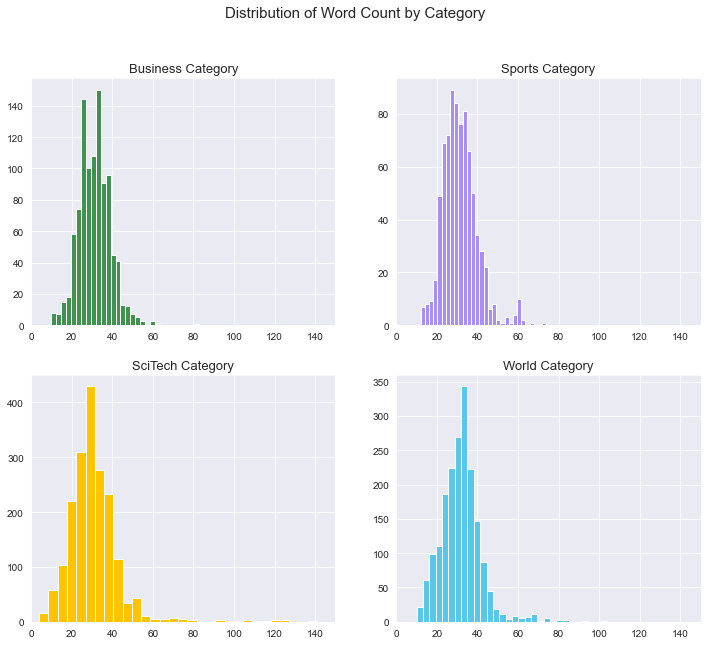

In [19]:
#Plotting the distribution of word count of articles against each category

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Business Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('SciTech Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Sports Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('World Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

## <a name="p5">Splitting the Data</a>

In [20]:
# Dividing the dataset into X and the target variable Y
X = df['clean_text'].astype('str') #features
y = df['label_num'] #target

print (X.shape)
print(y.shape)

(5590,)
(5590,)


In [21]:
#Train test split with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [22]:
# splitting the test set into further test and validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, 
                                                y_test,
                                                train_size=0.5,
                                                random_state=42,
                                                stratify=y_test)

## <a name="p6">TF-IDF Vectoriser</a>

In [23]:
#Creating the features (tf-idf weights) for the processed text
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)
tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))

In [24]:
# Transforming the X_train, X_val and X_test dataset on the fitted model
X_train = tfidf_vectorizer.transform(X_train)
X_test  = tfidf_vectorizer.transform(X_test)
X_val  = tfidf_vectorizer.transform(X_val)
print(f'Data Transformed.')

Data Transformed.


In [25]:
X_train.shape

(3913, 11455)

## <a name="p7">Dimensionality Reduction - TruncatedSVD</a>

In [26]:
#Dimenionality reduction. Only using the 500 best features er category
lsa = TruncatedSVD(n_components=500, 
                   n_iter=10, 
                   random_state=3)

lsa.fit(X_train)

TruncatedSVD(n_components=500, n_iter=10, random_state=3)

In [27]:
# Transforming the X_train,X_val and X_test dataset on the fitted model
X_train = lsa.transform(X_train)
X_test  = lsa.transform(X_test)
X_val  = lsa.transform(X_val)
print(f'Data Transformed.')

Data Transformed.


In [28]:
# Concatenate X_train and X_test to use it later for OneVsRestClassifier
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

## <a name="p8">Model Building and Evaluation</a>

In [29]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'LogisticRegression' : LogisticRegression(multi_class='multinomial'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'XGBoost': xgb.XGBClassifier(random_state=3, objective='multi:softmax', num_class=4),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

[17:34:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,LogisticRegression,0.83,0.83,0.80,0.81
5,XGBoost,0.79,0.78,0.78,0.78
2,Random Forest,0.77,0.78,0.74,0.75
4,AdaBoost,0.72,0.71,0.71,0.71
3,Decsision Tree,0.70,0.68,0.68,0.68
6,Gaussian Naive Bayes,0.64,0.69,0.69,0.64
7,K Nearest Neighbor,0.62,0.63,0.64,0.61
0,Dummy,0.27,0.25,0.25,0.25


Accuracy - simply the fraction of samples predicted correctly
Precision - the ratio of true positives to false positives or the ability of the classifier not to label a positive sample as negative
Recall - the ratio of true positives to false negatives or the ability of the classifier to find all the positive samples
F1 Score - The harmonic average of precision and recall
Precision-Recall Curve (graph): It shows the trade off between precision and recall. A high area under the curve (AUC) represents both high recall and high precision. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)

When the class distribution is unbalanced (like we have here), accuracy is considered a poor choice as it gives high scores to models which just predict the most frequent class so F1 score is a better choice in our case.

For multiclass classification we need to select the type of averaging for these metrics as they are calculated per class. I found macro averaging the most useful.

In Micro-average method, we sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them to get the statistics
Micro-average of precision = (TP1+TP2)/(TP1+TP2+FP1+FP2)
Micro-average of recall = (TP1+TP2)/(TP1+TP2+FN1+FN2)

In Macro-average method, we take the average of the precision and recall of the system on different sets.
Macro-average precision = (P1+P2)/2
Macro-average recall = (R1+R2)/2

If we have a data set with 90%-10% class distribution then a baseline classifier can achieve 90% accuracy by assigning the majority class label.
We can achieve a 90% micro-averaged accuracy. If the goal for my classifier is simply to maximize its hits and minimize its misses.
However, if we value the minority class the most, we should switch to a macro-averaged accuracy, where we would only get a 50% score. This metric is insensitive to the imbalance of the classes and treats them all as equal.

#### We see that Logistic Regression performs the best

## <a name="p8-1">Logistic Regression</a>

## Logistic Regression - Hyperparameter Tuning

In [30]:
#Hyperparameter tuning
#Gridsearch with 10-fold cross validation

#Logistic Regression
lg_model = LogisticRegression()

folds = KFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
              'penalty' : ['l1', 'l2'],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'max_iter' : [1000],
              'multi_class': ['multinomial']
             }

gridsearch = GridSearchCV(estimator = lg_model,
                          param_grid = param_grid,
                          cv = folds,
                          verbose = 1, 
                          n_jobs = -1)

log_best_model = gridsearch.fit(X_val, y_val)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 553 out of 560 | elapsed:  3.1min remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  3.5min finished


In [31]:
# Getting the best scores post hyperparameter tuning
print('We can get score of : ',gridsearch.best_score_,' using',gridsearch.best_params_)

We can get score of :  0.8224325874928284  using {'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}


In [32]:
# Defining the best models with the selected params from the grdsearch
log_best_model = LogisticRegression(C=10,
                                    max_iter=1000,
                                    multi_class='multinomial',
                                    penalty = 'l2',
                                    solver = 'newton-cg',
                                    random_state = 3)

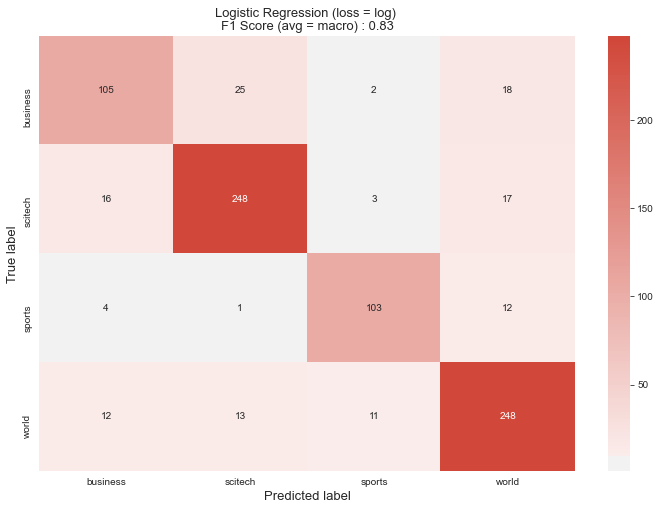

In [33]:
#Confusion Matrix - Logistic Regression

#Fit the training data
log_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = log_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Logistic Regression (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

In [34]:
# Printing the classification report across classes
cols = ['Business','SciTech','Sports','World']
print(metrics.classification_report(y_test, y_pred,target_names=cols))

              precision    recall  f1-score   support

    Business       0.77      0.70      0.73       150
     SciTech       0.86      0.87      0.87       284
      Sports       0.87      0.86      0.86       120
       World       0.84      0.87      0.86       284

    accuracy                           0.84       838
   macro avg       0.83      0.83      0.83       838
weighted avg       0.84      0.84      0.84       838



- OneVsRestClassifier - One-vs-the-rest (OvR) multiclass strategy
One-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.
Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier.

It involves splitting the multi-class dataset into multiple binary classification problems. A binary classifier is then trained on each binary classification problem and predictions are made using the model that is the most confident.

- For example, given a multi-class classification problem with examples for each class ‘red,’ ‘blue,’ and ‘green‘. This could be divided into three binary classification datasets as follows:

Binary Classification Problem 1: red vs [blue, green]

Binary Classification Problem 2: blue vs [red, green]

Binary Classification Problem 3: green vs [red, blue]

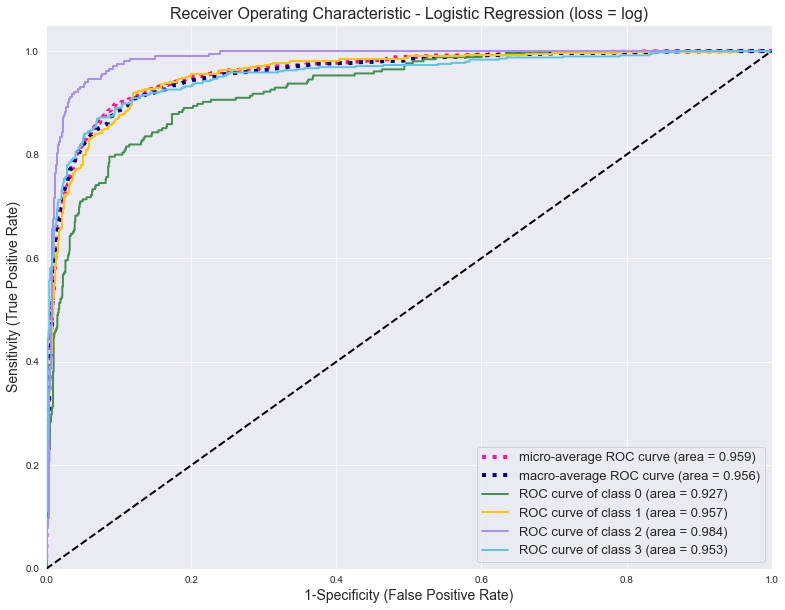

In [35]:
#Plot AUC for each classes using One vs Rest Classifier - Logistic Regression

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

# To predict each class against the other
log_classifier = OneVsRestClassifier(log_best_model)

y_score = log_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - Logistic Regression (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

### Testing further on the unseen text

In [36]:
#Putting it all together to make predictions on the unseen text

# Working on the copy of the dataframe as the same will be used later for ther model evaluation as well
df_holdout_bu = df_holdout.copy()

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout_bu['clean_text'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)


#Fit the models with the best params on the full data
log_best_model.fit(X_train, y_train)


#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout_bu['pred_label'] = log_best_model.predict(X_unseen)


label_num_dict = {'Business': 0,
                  'SciTech': 1,
                  'Sports': 2,
                  'World': 3}

df_holdout_bu['actual_label'] = df_holdout_bu['label'].map(label_num_dict)
df_holdout_bu = df_holdout_bu.drop('clean_text', 1)
df_holdout_bu = df_holdout_bu[['content', 'label', 'pred_label', 'actual_label']]

df_holdout_bu

,content,label,pred_label,actual_label
5051,If you #39;ve ever been in an airplane that ha...,Business,1,0
6272,NEW YORK (Reuters) - U.S. stocks rose on Monda...,Business,0,0
3341,US stocks looked to open flat on Thursday unde...,Business,0,0
6067,AP - The United States and Australia have prev...,Business,3,0
4673,NEW YORK (Reuters) - U.S. stocks jumped on Wed...,Business,0,0
4848,VIENNA (Reuters) - Top seed Amelie Mauresmo re...,Sports,2,2
6232,Feyenoord boss Ruud Gullit has launched a stin...,Sports,2,2
3072,Jim Mora thought his team deserved a little so...,Sports,2,2
6007,Motorsport.com. Reports this week suggest that...,Sports,1,2
4431,Race fans wave American flags in the stands du...,Sports,2,2


In [37]:
# Printing the classification report across labels
cols = ['Business','SciTech','Sports','World']
print(metrics.classification_report(df_holdout_bu.actual_label, df_holdout_bu.pred_label,target_names=cols))

              precision    recall  f1-score   support

    Business       0.75      0.60      0.67         5
     SciTech       0.57      0.80      0.67         5
      Sports       1.00      0.80      0.89         5
       World       0.60      0.60      0.60         5

    accuracy                           0.70        20
   macro avg       0.73      0.70      0.71        20
weighted avg       0.73      0.70      0.71        20



## <a name="p8-2">XGB Classifier</a>

## XGB Classifier - Hyperparameter Tuning

In [39]:
# Performing RandomizedSearchCV for hyperparameter tuning
xgb_cfl = xgb.XGBClassifier(random_state=3, objective='multi:softmax', num_class=4)

params = {
        'n_estimators' : [100, 200, 500, 750, 1000], # no of trees 
        'learning_rate' : [0.001, 0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'gamma' : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.2,0.4,0.6, 0.8, 1.0],
        'colsample_bytree': [0.3,0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [1, 1.5, 2, 3, 4.5],
        'max_depth': [3, 4, 5, 10, 12]
        }


folds = 5
param_comb = 100

random_search = RandomizedSearchCV(xgb_cfl, scoring = "f1_macro", param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=folds, verbose=3, random_state=42)

# Fitting on the validation set
random_search.fit(X_val, y_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 83.5min finished


[16:40:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'colsample_bytree': [0.3, 0.6, 0.8,
                                                             1.0],
                                      

In [40]:
# Printing the best score that we can get using the parameters
print('We can get score of :',random_search.best_score_,' using',random_search.best_params_)

We can get score of : 0.7999889278960151  using {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 750, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [41]:
# Creating XGBRegression model with the select hyperparameters
xgb_class_hpt = xgb.XGBClassifier(subsample=0.6, reg_lambda=1.5, reg_alpha=0, n_estimators=750, min_child_weight=1, max_depth=12,
                               learning_rate=0.1, gamma=0.1, colsample_bytree=0.8, objective='multi:softmax', num_class=4, n_jobs = -1)

[16:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


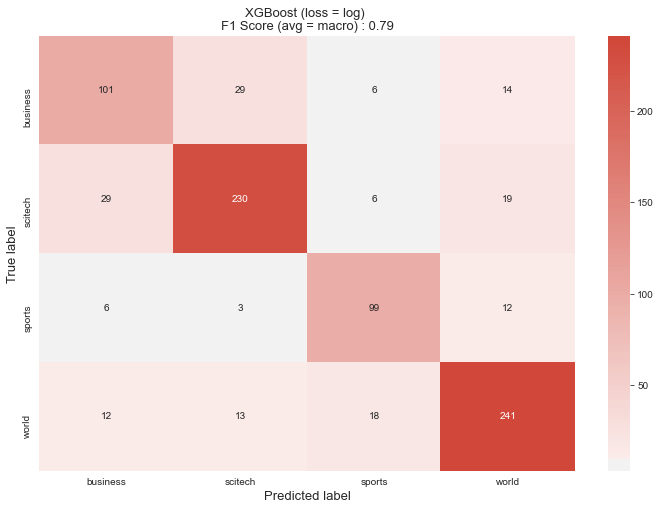

In [42]:
#Confusion Matrix - XGBoost

#Fit the training data
xgb_class_hpt.fit(X_train, y_train)

#Predict the testing data
y_pred = xgb_class_hpt.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('XGBoost (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

In [43]:
# Printing the classification report across classes
cols = ['Business','SciTech','Sports','World']
print(metrics.classification_report(y_test, y_pred,target_names=cols))

              precision    recall  f1-score   support

    Business       0.68      0.67      0.68       150
     SciTech       0.84      0.81      0.82       284
      Sports       0.77      0.82      0.80       120
       World       0.84      0.85      0.85       284

    accuracy                           0.80       838
   macro avg       0.78      0.79      0.79       838
weighted avg       0.80      0.80      0.80       838



[16:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

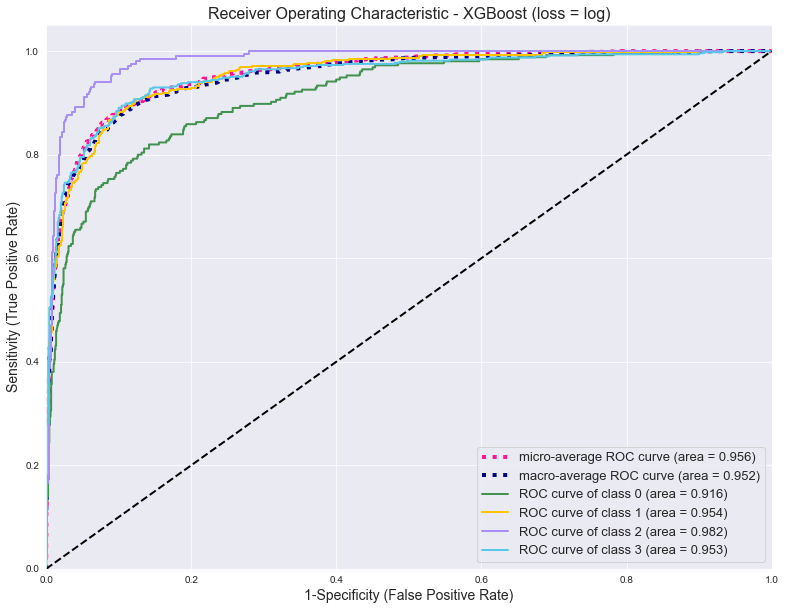

In [44]:
#Plot AUC - XGBoost

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
xgb_classifier = OneVsRestClassifier(xgb_class_hpt)

y_score = xgb_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - XGBoost (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

### Testing further on the unseen text

In [45]:
#Putting it all together to make predictions on the unseen text

df_holdout_bu = df_holdout.copy()

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout_bu['clean_text'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
# xgb_class_hpt.fit(X, y)
# rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout_bu['pred_sgd'] = xgb_class_hpt.predict(X_unseen)
# df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Business': 0,
                  'SciTech': 1,
                  'Sports': 2,
                  'World': 3}

df_holdout_bu['correct'] = df_holdout_bu['label'].map(label_num_dict)
df_holdout_bu = df_holdout_bu.drop('clean_text', 1)
df_holdout_bu = df_holdout_bu[['content', 'label', 'pred_sgd', 'correct']]

df_holdout_bu

,content,label,pred_sgd,correct
5051,If you #39;ve ever been in an airplane that ha...,Business,1,0
6272,NEW YORK (Reuters) - U.S. stocks rose on Monda...,Business,0,0
3341,US stocks looked to open flat on Thursday unde...,Business,0,0
6067,AP - The United States and Australia have prev...,Business,3,0
4673,NEW YORK (Reuters) - U.S. stocks jumped on Wed...,Business,0,0
4848,VIENNA (Reuters) - Top seed Amelie Mauresmo re...,Sports,2,2
6232,Feyenoord boss Ruud Gullit has launched a stin...,Sports,2,2
3072,Jim Mora thought his team deserved a little so...,Sports,2,2
6007,Motorsport.com. Reports this week suggest that...,Sports,1,2
4431,Race fans wave American flags in the stands du...,Sports,2,2


In [46]:
# Printing the classification report across classes
cols = ['Business','SciTech','Sports','World']
print(metrics.classification_report(df_holdout_bu.correct, df_holdout_bu.pred_sgd,target_names=cols))

              precision    recall  f1-score   support

    Business       0.75      0.60      0.67         5
     SciTech       0.57      0.80      0.67         5
      Sports       1.00      0.80      0.89         5
       World       0.60      0.60      0.60         5

    accuracy                           0.70        20
   macro avg       0.73      0.70      0.71        20
weighted avg       0.73      0.70      0.71        20



## We see that Logistic Regression performs better on F1 score, hence we would proceed with the same.